# Using a pretrained Vision Transformer to diagnose Alzheimer's disease from a 2D slice of an MRI scan
We are going to build our vision transformer using PyTorch, so we will need to import the library and some other important packages.

In [1]:
# Vision Transformer Code for Training and Testing on MRI Images

# Chunk 1: Import Required Libraries
import os
import numpy as np
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from timm.models.vision_transformer import vit_base_patch16_224_in21k

# Verify GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/opt/anaconda3/envs/huggingface_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### Chunk 2: Dataset Preparation

In [2]:
# Defines a PyTorch dataset for loading and preprocessing MRI image data
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = [path for path in self.root_dir.glob("**/*.png") if path.is_file()]
        self.labels = [0 if "HC" in str(path.parent) else 1 for path in self.image_paths]  # 0: HC, 1: AD

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = MRIDataset(root_dir="MRI/train", transform=transform)
test_dataset = MRIDataset(root_dir="MRI/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"Loaded {len(train_dataset)} training samples and {len(test_dataset)} testing samples.")

Loaded 653 training samples and 247 testing samples.


### Chunk 3: Define the Vision Transformer Model

In [3]:
# Load pre-trained Vision Transformer
model = vit_base_patch16_224_in21k(pretrained=True)

# Modify the classifier head for binary classification
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)

model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Model defined and ready for training!")

/var/folders/qr/pvnm2ntd1gq89m73p8vhvccc0000gn/T/ipykernel_54361/1118417850.py:2: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = vit_base_patch16_224_in21k(pretrained=True)


Model defined and ready for training!


### Chunk 4: Training Loop

In [4]:
# Chunk 4: Training Loop
num_epochs = 6
train_accuracies = []

def train_model():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Save the model after each epoch
        torch.save(model.state_dict(), f"vision_transformer_epoch_{epoch+1}.pth")
        print(f"Model saved as vision_transformer_epoch_{epoch+1}.pth")

print("Starting training...")
train_model()

Starting training...
Epoch 1/6, Loss: 0.6166, Accuracy: 65.54%
Model saved as vision_transformer_epoch_1.pth
Epoch 2/6, Loss: 0.4911, Accuracy: 77.34%
Model saved as vision_transformer_epoch_2.pth
Epoch 3/6, Loss: 0.3579, Accuracy: 86.06%
Model saved as vision_transformer_epoch_3.pth
Epoch 4/6, Loss: 0.3182, Accuracy: 86.52%
Model saved as vision_transformer_epoch_4.pth
Epoch 5/6, Loss: 0.2693, Accuracy: 88.36%
Model saved as vision_transformer_epoch_5.pth
Epoch 6/6, Loss: 0.2745, Accuracy: 88.82%
Model saved as vision_transformer_epoch_6.pth


### Chunk 6: Plot Training Accuracy

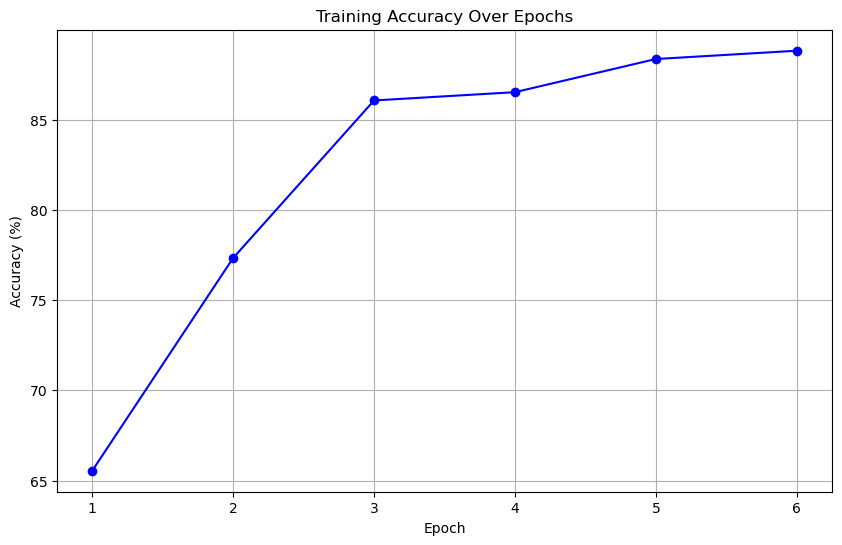

In [5]:
import matplotlib.pyplot as plt

# Plot our accuracy
def plot_training_accuracy():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-', color='b')
    plt.title("Training Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.show()

# Call this function after training to visualize accuracy
plot_training_accuracy()